In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Any results you write to the current directory are saved as output.

/kaggle/input/fast-ai-resnext101/submissionresnext101_64x4d.csv
/kaggle/input/fast-ai-resnext101/custom.css
/kaggle/input/fast-ai-resnext101/__notebook__.ipynb
/kaggle/input/fast-ai-resnext101/__results__.html
/kaggle/input/fast-ai-resnext101/__output__.json
/kaggle/input/fast-ai-resnext101/resnext101_64x4d_stage-2.pth
/kaggle/input/fast-ai-resnext101/tmp.pth
/kaggle/input/fast-ai-resnext101/__results___files/__results___14_2.png
/kaggle/input/fast-ai-resnext101/__results___files/__results___17_1.png
/kaggle/input/fast-ai-resnext101/__results___files/__results___4_0.png
/kaggle/input/fast-ai-resnext101/__results___files/__results___17_2.png
/kaggle/input/ifood-2019-fgvc6/test_set.zip
/kaggle/input/ifood-2019-fgvc6/train_labels.csv
/kaggle/input/ifood-2019-fgvc6/ifood2019_sample_submission.csv
/kaggle/input/ifood-2019-fgvc6/val_set.zip
/kaggle/input/ifood-2019-fgvc6/train_set.zip
/kaggle/input/ifood-2019-fgvc6/val_labels.csv
/kaggle/input/ifood-2019-fgvc6/sample_submission.csv
/kaggle/i

In [2]:
from zipfile import ZipFile
import shutil

if not os.path.exists("./train_set"):
    for file_name in ['train_set.zip', 'val_set.zip', 'test_set.zip']:
        with ZipFile('../input/ifood-2019-fgvc6/' + file_name, 'r') as zipObj:
            print("unzipping", file_name)
            zipObj.extractall('./')

for dirname, _, _ in os.walk('./'):
    print(dirname)

unzipping train_set.zip
unzipping val_set.zip
unzipping test_set.zip
./
./test_set
./val_set
./train_set


In [3]:
df_train = pd.read_csv('../input/ifood-2019-fgvc6/train_labels.csv')
df_val   = pd.read_csv('../input/ifood-2019-fgvc6/val_labels.csv')
df_test = pd.read_csv('../input/ifood-2019-fgvc6/sample_submission.csv')
df_train['path'] = df_train['img_name'].map(lambda x: os.path.join('./train_set/', x))
df_val['path'] = df_val['img_name'].map(lambda x: os.path.join('./val_set/', x))
df_test['path'] = df_test['img_name'].map(lambda x: os.path.join('./test_set/', x))
num_classes = df_train['label'].nunique()

df = pd.concat([df_train, df_val], ignore_index=True)
val_idx = [i for i in range(len(df_train), len(df))]
df.head()

,img_name,label,path
0,train_101733.jpg,211,./train_set/train_101733.jpg
1,train_101734.jpg,211,./train_set/train_101734.jpg
2,train_101735.jpg,211,./train_set/train_101735.jpg
3,train_101736.jpg,211,./train_set/train_101736.jpg
4,train_101737.jpg,211,./train_set/train_101737.jpg


In [4]:
! pip install pretrainedmodels

import matplotlib.pyplot as plt
%matplotlib inline  

from fastai import *
from fastai.vision import *
from tqdm import tqdm

input_size = 256
batch_size = 24
np.random.seed(78)

tfms = get_transforms(do_flip=True, max_rotate=360, max_zoom=1.2, 
                      max_lighting=0.5, p_lighting=0.5, p_affine=0.5)
data= (ImageList.from_df(df=df, path='./', cols='path')
       .split_by_idx(val_idx)
       .label_from_df(cols='label')
       .add_test_folder('./test_set')
       .transform(tfms, size=input_size, resize_method=ResizeMethod.SQUISH, padding_mode='border') #Data augmentation
       .databunch(bs=batch_size, num_workers=4)
       .normalize(imagenet_stats)
       )

def top_3_accuracy(preds, targs):
    return top_k_accuracy(preds, targs, 3)

     |████████████████████████████████| 58 kB 2.2 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=2e377b793e70e396d0239b5cee9c8b16f7e0f219add09e6d17b88b9ff3c10c37
  Stored in directory: /root/.cache/pip/wheels/9c/03/81/494596f1d017bbf80daf53bc33dbb05aaa5a6ad6d44c74011f
Successfully built pretrainedmodels


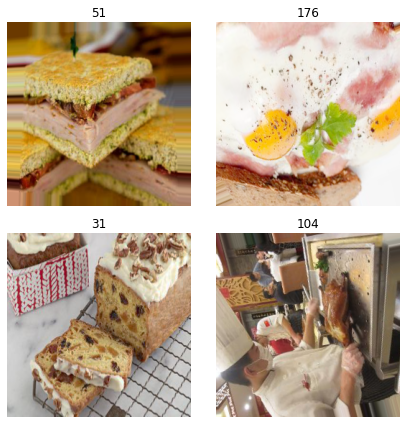

In [5]:
data.show_batch(rows=2, figsize=(6,6))

In [6]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [7]:
from torchvision import models as torchmodels
import pretrainedmodels

print(pretrainedmodels.__dict__.keys())
print()
print(torchmodels.__dict__.keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'version', '__version__', 'models', 'datasets', 'pretrained_settings', 'model_names', 'fbresnet152', 'cafferesnet101', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'nasnetalarge', 'nasnetamobile', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'pnasnet5large', 'polynet'])

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'utils', 'alexnet', 'AlexNet',

In [8]:
# class new_pnasnet(nn.Module):
#     def __init__(self, md, nout):
#         super().__init__()
#         self.md = md
#         self.lin2 = nn.Linear(1000, 512)
#         self.lin3 = nn.Linear(512, nout)
#         self.d1 = nn.Dropout(0.5)
        
#     def forward(self, inp):
#         # import pdb
#         # pdb.set_trace()
#         out1 = F.relu(self.md(inp))
#         out2 = self.d1(F.relu(self.lin2(out1)))
#         out3 = self.lin3(out2)
#         return F.log_softmax(out3, dim=-1)

In [9]:
# model_name = 'se_resnext101_32x4d'
model_name = 'resnext101_64x4d'
# model_name = 'pnasnet5large'
# model_name = 'inceptionresnetv2'

! mkdir -p /root/.cache/torch/checkpoints
# ! cp ../input/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth /root/.cache/torch/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth
# ! cp ../input/pretrainedmodels/pnasnet5large-bf079911.pth /root/.cache/torch/checkpoints/pnasnet5large-bf079911.pth
# ! cp ../input/pretrainedmodels/inceptionresnetv2-520b38e4.pth /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth
! cp ../input/pretrained-models/resnext101_64x4d-e77a0586.pth /root/.cache/torch/checkpoints/resnext101_64x4d-e77a0586.pth

# def pnasnet5large(pretrained=False, output_classes=1):
#     pretrained = 'imagenet' if pretrained else None
#     model = pretrainedmodels.__dict__['pnasnet5large'](num_classes=1000, pretrained='imagenet')
#     new_last_linear = nn.Linear(model.last_linear.in_features, output_classes)
#     model.last_linear = new_last_linear
#     return model

def get_model(pretrained=True, model_name=model_name):
    pretrained = 'imagenet' if pretrained else None
    arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained="imagenet")
    return arch

In [10]:
learner = None
# if model_name == 'pnasnet5large':
#     learner = cnn_learner(data, pnasnet5large, 
#                           metrics=[top_3_accuracy], model_dir='./', 
#                           loss_func = LabelSmoothingCrossEntropy()).mixup()
# else:
# model = new_pnasnet(model, num_classes)
learner = cnn_learner(data, get_model, metrics=[top_3_accuracy], model_dir='./', 
                      loss_func = LabelSmoothingCrossEntropy()).mixup()

In [11]:
# learner.lr_find()
# learner.recorder.plot(suggestion=True)

In [12]:
# stage = 1
# csvlogger = callbacks.CSVLogger(learn=learner, 
#                                 filename='history_stage_'+str(stage)+'_'+model_name, 
#                                 append=True)
# saveModel = callbacks.SaveModelCallback(learner, 
#                                         every='epoch',
#                                         monitor='top_3_accuracy', 
#                                         mode='max',
#                                         name='stage_'+str(stage))
# reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learner, 
#                                                monitor='top_3_accuracy', 
#                                                mode='max', 
#                                                patience=1, 
#                                                factor=0.5)

In [13]:
# lr = 3e-3
# learner.fit_one_cycle(5, slice(lr))

In [14]:
# learner.recorder.plot_losses()
# learner.recorder.plot_metrics()
# learner.save(model_name+'_stage-1', return_path=True)

epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.09E-06


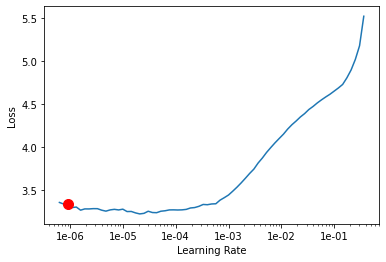

In [15]:
learner.load('../input/fast-ai-resnext101/resnext101_64x4d_stage-2')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [16]:
stage = 3
csvlogger = callbacks.CSVLogger(learn=learner, 
                                filename='history_stage_'+str(stage)+'_'+model_name, 
                                append=True)
saveModel = callbacks.SaveModelCallback(learner, 
                                        every='epoch',
                                        monitor='top_3_accuracy', 
                                        mode='max',
                                        name='stage_'+str(stage))
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learner, 
                                               monitor='top_3_accuracy', mode='max', 
                                               patience=1, 
                                               factor=0.5)


In [17]:
learner.fit_one_cycle(2, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,top_3_accuracy,time
0,3.295970,2.036021,0.852676,1:36:03
1,3.261195,1.993953,0.857762,1:35:57


PosixPath('resnext101_64x4d_stage-2.pth')

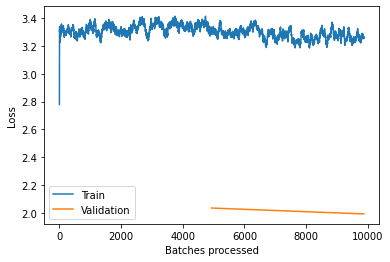

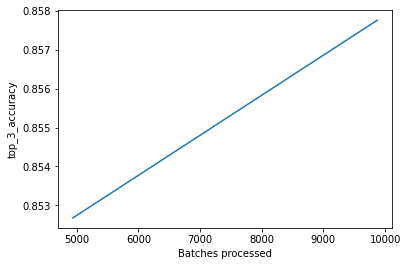

In [18]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()
learner.save(model_name+'_stage-2', return_path=True)

In [19]:
preds, _ = learner.get_preds(ds_type=DatasetType.Test)
fnames = [f.name for f in learner.data.test_ds.items]
test_df = pd.DataFrame(fnames, columns=['img_name'])
test_df['label'] = ''
predictions = np.array(preds).reshape(len(preds), num_classes)

from tqdm import tqdm_notebook as T
for i, pred in T(enumerate(predictions), total=len(predictions)):
    test_df.loc[i, 'label'] = ' '.join(str(int(i)) for i in np.argsort(pred)[::-1][:3])
    
test_df.to_csv('submission'+model_name+'.csv', index=False)
test_df.head(15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,img_name,label
0,test_005204.jpg,1 223 99
1,test_013579.jpg,1 46 237
2,test_004744.jpg,30 210 34
3,test_010758.jpg,193 19 220
4,test_021491.jpg,1 160 19
5,test_010355.jpg,25 84 38
6,test_001416.jpg,215 93 47
7,test_017275.jpg,80 210 123
8,test_018361.jpg,179 112 165
9,test_015497.jpg,178 95 181


In [20]:
import shutil

for path in['./train_set', './val_set', './test_set']:
    shutil.rmtree(path)